<img src="https://kenya.ai/wp-content/uploads/2020/05/Mckinsey-prohack.png" width="1000px"> 
# International Data Science Hackathon by McKinsey & Company



**by team GORNYAKI (Tsepa Oleksii and Samoshin Andriy [Ukraine, KPI, IASA])**

Thanks to the organizers for this hackathon and everyone for participating! In this notebook you will find:

* **feature engeneering**
* **feature selection**
* **modeling**
* **optimization part**
* **which things didn't help us to improve score**

For those who hear about this competition for the first time, you can familiarize yourself with the condition [here](https://prohack.org/). All data is located [here](https://www.kaggle.com/mrmorj/prohack-hackathon).

[The firs part, where we talk about our EDA & Preprocessing.](https://www.kaggle.com/mrmorj/prohack-hackathon-part-1-eda-preprocessing)

<b><font size="4">Importing libraries</font></b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

seed = 47

In [2]:
train_start = pd.read_csv('/kaggle/input/prohack-all-data/train_preproc_ploxa_interpol.csv')
test_start = pd.read_csv('/kaggle/input/prohack-all-data/test_preproc_ploxa_interpol.csv')
sample_submit = pd.read_csv('/kaggle/input/prohack-all-data/sample_submit.csv')

# Feature engeneering
<b><font size="4">Some tips</font></b>

After preprocessing part, where we tried to handle with missing data, there were still some NaN's. It was decided to insert the average value with respect to each columns. 

In [3]:
df = pd.concat([train_start,test_start], ignore_index=True)

for col in test_start.iloc[:,:-2].columns.values:
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)

Also quite interesting thing that if we renumber 'galactic years' from sorted initial values to numbers from 1 to 27, we'll got better score.

In [4]:
print('Initial years: ', df['galactic year'].unique())

df=df.replace(df['galactic year'].unique(), list(np.arange(1, 28)))

print('Modified years: ', df['galactic year'].unique())

total_df = df.copy()

Initial years:  [ 990025  991020  992016  993012  994009  995006  996004  997002  998001
  999000 1000000 1001000 1002001 1003002 1004004 1005006 1006009 1007012
 1008016 1009020 1010025 1011030 1012036 1013042 1014049 1015056 1016064]
Modified years:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


<b><font size="4">Fixing outliers</font></b>

We found that some columns have got outliers which degrades model performance. So we choose columns which have got lots of outliers and deleted them(we made sections with outliers more smoother).

In [5]:
col_interp = ['existence expectancy index', 
       'existence expectancy at birth',
       'Gross income per capita', 
       'Income Index',
       'Expected years of education (galactic years)',
       'Mean years of education (galactic years)', 
       'Education Index',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)',
       'Population, urban (%)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Population, ages 15–64 (millions)',
       'Population, ages 65 and older (millions)',
       'Life expectancy at birth, male (galactic years)',
       'Total unemployment rate (female to male ratio)',
       'Employment to population ratio (% ages 15 and older)',
       'Exports and imports (% of GGP)',
       'Estimated gross galactic income per capita, male',
       'Estimated gross galactic income per capita, female',
       'Domestic credit provided by financial sector (% of GGP)',
       'Remittances, inflows (% of GGP)',
       'Population with at least some secondary education (% ages 25 and older)',
       'Gross enrolment ratio, primary (% of primary under-age population)',
       'Current health expenditure (% of GGP)',
       'Intergalactic Development Index (IDI), female',
       'Intergalactic Development Index (IDI), male',
       'Gender Development Index (GDI)',
       'Gender Inequality Index (GII)']

In [6]:
unique_gal = list(df.galaxy.unique())

total_df_new = pd.DataFrame()
for gal in unique_gal:
    temp = total_df[total_df.galaxy==gal]
    temp = temp.sort_values(by=['galactic year'], ascending=True).reset_index()
    for c in col_interp:
        for numb in range(2):
            pr = temp[c].diff()/temp[c].mean()
            low_diff = pr[(pr>0.15) | (pr<-0.15)]
            for ind in (low_diff.index.values):
                if (ind!=0) and (ind!=(len(temp))):
                    temp.loc[ind, c] = np.nan
                    temp.loc[ind-1:ind+1, c] = temp.loc[ind-1:ind+1, c].interpolate()
    total_df_new = pd.concat([total_df_new, temp])

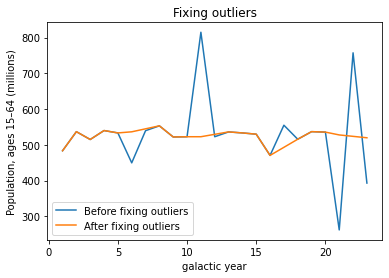

In [7]:
temp=df[df['galaxy']=='Hercules Dwarf'].sort_values(by=['galactic year'], ascending=True)
sns.lineplot(x=temp['galactic year'], y=temp['Population, ages 15–64 (millions)'], label='Before fixing outliers')
temp1=total_df_new[total_df_new['galaxy']=='Hercules Dwarf'].sort_values(by=['galactic year'], ascending=True)
sns.lineplot(x=temp1['galactic year'], y=temp1['Population, ages 15–64 (millions)'], label='After fixing outliers').set_title('Fixing outliers')
plt.legend(loc=3)
plt.show()

In [8]:
total_df_new = total_df_new.sort_values(by='index').reset_index()
total_df_new = total_df_new.drop(labels=['level_0', 'index'], axis=1)

train = total_df_new[:len(train_start.index)]
test = total_df_new[len(train_start.index):]

We also used RobustScaler for fixing outliers.
> This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
> 
> Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.
> 
> Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

In [9]:
scaler = preprocessing.RobustScaler(quantile_range=(15,70))

target = train['y']

train_num = train.drop(labels=['y', 'galaxy'], axis=1)
test_num = test.drop(labels=['galaxy', 'y'], axis=1)

train_num_cols = list(train_num.columns)
test_num_cols  = list(test_num.columns)

train_num = scaler.fit_transform(train_num)
test_num = scaler.transform(test_num)

train_num = pd.DataFrame(train_num, columns=train_num_cols)
test_num = pd.DataFrame(test_num, columns=test_num_cols)

<b><font size="4">Categorical target</font></b>

As you see, we made 3 classes of our target to use StratifiedKFold. This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [10]:
cat_target = target.copy()
for i, num in enumerate(target):
    if num>0.2:
        cat_target[i]='high'
    elif num<0.1:
        cat_target[i]='low'
    else:
        cat_target[i]='mid'

In [11]:
print('Distribution of classes: ')
print(cat_target.value_counts())

Distribution of classes: 
low     3049
mid      593
high     223
Name: y, dtype: int64


# Feature selection
We used this function to select the columns with which our model works best. Feature selection was performed using cross validation. This function is not the most optimal in its speed, but it was enough for this task. It drops one column at a time and perform cross validation, then chose a set with the best result and repeat steps below up to the moment when cross validation fall down.

In [12]:
def feature_selection(train_num, model):

    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    train_copy = train_num.copy()
    res_base=[]

    for i, (tdx, vdx) in enumerate(stkfold.split(train_copy, cat_target)):
        X_train, X_valid, y_train, y_valid = train_copy.iloc[tdx], train_copy.iloc[vdx], target.iloc[tdx], target.iloc[vdx]
        model.fit(X_train, y_train)
        preds=model.predict(X_valid)
        res_base.append(mean_squared_error(y_valid, preds, squared=False))

    baseline = np.mean(res_base)

    while True:
        cols = list(train_copy.columns)
        drop_rmse = []
        for drop_col in tqdm(cols):

            train_drop = train_copy.drop(labels=[drop_col], axis=1)
            res=[]

            for i, (tdx, vdx) in enumerate(stkfold.split(train_copy, cat_target)):
                X_train, X_valid, y_train, y_valid = train_drop.iloc[tdx], train_drop.iloc[vdx], target.iloc[tdx], target.iloc[vdx]
                model.fit(X_train, y_train)
                preds=model.predict(X_valid)
                res.append(mean_squared_error(y_valid, preds, squared=False))

            drop_rmse.append(np.mean(res))
        drop_df = pd.DataFrame(list(zip(drop_rmse, cols)), columns =['RMSE', 'Column'])
        drop_df=drop_df.sort_values(by=['RMSE'], ascending=True)
        print(drop_df.head())

        if baseline > drop_df.iloc[0, 0]:
            baseline = drop_df.iloc[0, 0]
            train_copy = train_copy.drop(labels=[drop_df.iloc[0, 1]], axis=1)
            print(f"RMSE: {round(baseline,8)}, num_cols:{len(train_copy.columns)}, dropped:{list(set(train_num.columns) - set(train_copy.columns))}") 
        else:
            print('nothing better')
            break

In [13]:
#feature_selection(train_num, xgb)

After using this function, we dropped about 15 columns. Then with help of correlation matrix were dropped some high corellated columns, because it's not the best idea to have few linear combinations of one or few columns in dataset. This trick didn't bring score increase in cross validation, but it gives in leaderboard.

So after two steps bellow we got next columns:

In [14]:
col_xgb = ['existence expectancy at birth',
           'Gross income per capita', 
           'Expected years of education (galactic years)',
           'Mean years of education (galactic years)', 
           'Education Index',
           'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
           'Population, ages 15–64 (millions)',
           'Population, ages 65 and older (millions)',
           'Total unemployment rate (female to male ratio)',
           'Exports and imports (% of GGP)',
           'Estimated gross galactic income per capita, female',
           'Domestic credit provided by financial sector (% of GGP)',
           'Population with at least some secondary education (% ages 25 and older)',
           'Gross enrolment ratio, primary (% of primary under-age population)',
           'Current health expenditure (% of GGP)',
           'Gender Development Index (GDI)',
           'Gender Inequality Index (GII)', 
           'galactic year',
           'galaxy_cb']

In [15]:
train_num_xgb_def = train_num.copy()
test_num_xgb_def = test_num.copy()

col = col_xgb

train_num_xgb_def = train_num_xgb_def[col]
test_num_xgb_def = test_num_xgb_def[col]

xgb=XGBRegressor(verbosity=1, random_state=seed)
stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Modeling
<b><font size="4">Cross validation</font></b>

As I said earlier, we used StratifiedKFold cross validation, which works as it shown on photo.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500px"> 

Moreover we predict test set with this technique. Model fits on each X_train, predict test set and final result is made by averaging of all predictions on test set.

cv:  0.00726135


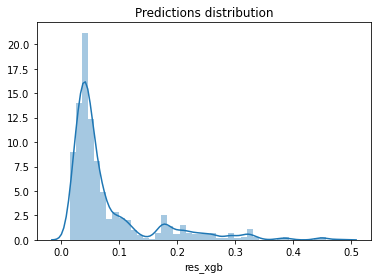

In [16]:
res=[]
probs = pd.DataFrame()

for i, (tdx, vdx) in enumerate(stkfold.split(train_num_xgb_def, cat_target)):
    X_train, X_valid, y_train, y_valid = train_num_xgb_def.iloc[tdx], train_num_xgb_def.iloc[vdx], target[tdx], target[vdx]
    xgb.fit(X_train, y_train)
    preds=xgb.predict(X_valid)
    oof_predict = xgb.predict(test_num_xgb_def)
    probs['fold_%i'%i] = oof_predict
    res.append(mean_squared_error(y_valid, preds, squared=False))

print('cv: ', round(np.mean(res),8))  

probs['res_xgb'] = probs.mean(axis=1)
sns.distplot(probs['res_xgb']).set_title('Predictions distribution')
plt.show()

<b><font size="4">Feature importance</font></b>

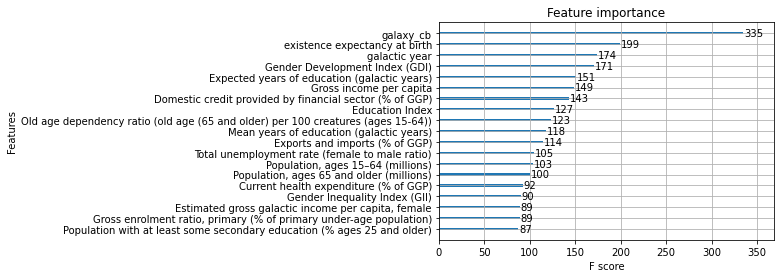

In [17]:
from xgboost import plot_importance

plot_importance(xgb)
plt.show()

# Stacking
We used small stack with LightGBM in proportions 80/20 with respect to XGBoost.

<img src="https://github.com/imgremlin/Photos/blob/master/Untitled%20Diagram.png?raw=true" width="400px"> 

LightGBM has got next parameters:

In [18]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(objective='regression', verbose=-1, random_state=seed, 
                     learning_rate=0.2,n_estimators=900, boosting='dart',num_leaves=5)

# Optimization
We used SciPy for 2nd optimization task. 

In [19]:
df_opt = pd.DataFrame()

df_opt['pred'] = probs['res_xgb']
df_opt['smpl_opt_pred'] = sample_submit['opt_pred']
df_opt['existence expectancy index'] = test['existence expectancy index']
df_opt['const'] = df_opt['pred'].apply(lambda x: ((3-np.log(x+0.01))**2)/1000)

df_opt = df_opt.sort_values(by='existence expectancy index')

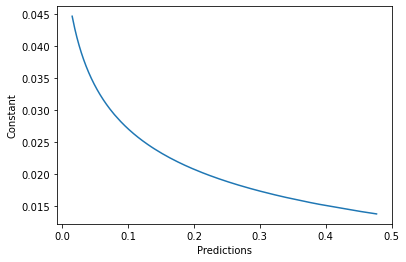

In [20]:
sns.lineplot(x=df_opt['pred'],y=df_opt['const'])
plt.xlabel('Predictions')
plt.ylabel('Constant')
plt.show()

We counted and found out that exists 67 countries with 'existence expectancy index' < 0.7. So it was made up a system of equations:
<img src="https://github.com/imgremlin/Photos/blob/master/Screenshot%20(21).png?raw=true" width="350px"> 

In [21]:
from scipy.optimize import minimize

x0 = np.array(df_opt['smpl_opt_pred'])
consts = np.array(df_opt['const'])

def objective(x):
    return -x.dot(consts)

def constraint1(x):
    return 49999.99-sum(x)

def constraint2(x):
    return sum(x[:67])-4999.99

b = (0.0, 100.0)
bnds = (b,)*890

con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
cons = ([con1,con2])
solution = minimize(objective,x0,method='SLSQP',
                    bounds=bnds,constraints=cons)

x = solution.x
print('result:',-1*objective(x))

result: 1818.340612826218


Code for optimization below won't give the best score for 2nd task. 

Few reasons:
* we empirically found x0 - initial vector
* we used another parameters in constraints

# What didn't help
<b><font size="4">CatBoost</font></b>
<img src="https://camo.githubusercontent.com/1ba204e6a09e6f13c919dcf961fe5a9a7f2d6e30/687474703a2f2f73746f726167652e6d64732e79616e6465782e6e65742f6765742d646576746f6f6c732d6f70656e736f757263652f3235303835342f636174626f6f73742d6c6f676f2e706e67" width="300px"> 
We tried to add CatBoost to stack but it didn't give score improvement.

<b><font size="4">Normalization of the target</font></b>

We tried to normalize target to make it less skewed, and to shorten the right tail.
For this approach we used:
* Square Root Transformation
* Log Transformation
* Box Cox Transformation

But any of them didn't bring good result. In my opinion because our dataset was also skewed in some way. And because of this, the normalized target was discordant with the skewed dataset.

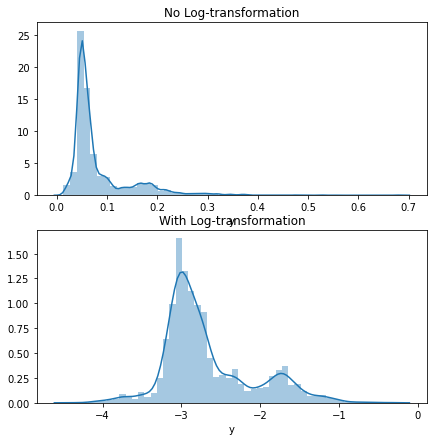

In [22]:
f, axes = plt.subplots(2,1, figsize=(7, 7))
sns.distplot(target,ax=axes[0]).set_title('No Log-transformation')
sns.distplot(np.log(target),ax=axes[1]).set_title('With Log-transformation')
plt.show()

<b><font size="4">Remove rows-outliers from train set</font></b>

We tried to detect outliers in train set by cross_val_predict and drop them. If the true value and the predicted difference in absolute value greater than 0.1, then this row is considered to be an outlier. But maybe cause our model a little bit overfitted, we didn't get improvement.

Is row an outlier?
False    3838
True       27
Name: y, dtype: int64


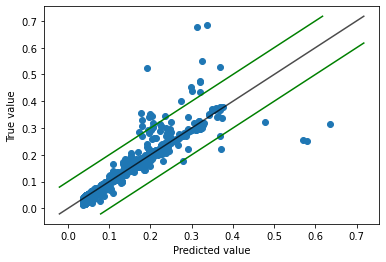

In [23]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(xgb, train_num_xgb_def, target, cv=5)

fig, ax = plt.subplots()
ax.scatter(y=target,x=y_pred)
ax.set_xlabel('Predicted value')
ax.set_ylabel('True value')

minimum = np.min([ax.get_xlim(), ax.get_ylim()])
maximum = np.max([ax.get_xlim(), ax.get_ylim()])

lims = [minimum, maximum]
k=0.1

ax.plot(lims, lims, 'k-', alpha=0.7)
ax.plot([minimum, maximum-k], [minimum+k, maximum], 'g-')
ax.plot([minimum+k, maximum], [minimum, maximum-k], 'g-')

mask = np.absolute(y_pred-target)>k
print('Is row an outlier?')
print(mask.value_counts())

<b><font size="4">Rollings Statistics</font></b>

Because we have got not so big time window for each galaxy(about 20-30 values), it was rather hard to implement rolling statistics for each galaxy. But in truth, the rolling statistics gave an increase, but we decided not to use them.

The second part is over! If you missed first part, click [here](https://www.kaggle.com/mrmorj/prohack-hackathon-part-1-eda-preprocessing).